In [2]:
import Pkg; 

if split(pwd(),"/")[end] == "prototyping"
    cd(joinpath(@__DIR__, "../../"))
    Pkg.activate("Project.toml")
end

using MorphoMolNotebooks
using MorphoMol
using JLD2
using GLMakie
using GeometryBasics
using Distances
using Random

In [3]:
function get_interface_visualization(points::Vector{Vector{Float64}}, n_atoms_per_mol::Int; show_wireframe = false)
    labels = MorphoMol.Energies.get_labels(length(points), n_atoms_per_mol) 
    get_interface_visualization(points, labels, show_wireframe = show_wireframe)
end

function get_interface_visualization(points::Vector{Vector{Float64}}, labels::Vector{Int}; show_wireframe = false)
    bcs, filtration = MorphoMol.Energies.get_barycentric_subdivision_and_filtration(points, labels)

    max_v = maximum([v for (_, v) in filtration]) / 2.0
    min_v = minimum([v for (_, v) in filtration])
    
    f = Figure(fontsize = 12)
    title_fs = 15
    ms = 15
    cm = :Dark2_8
    cr = (1,8)

    i_sc = LScene(f[1:2, 1:2], show_axis=false, scenekw = (lights = [AmbientLight(RGBf(1.0, 1.0, 1.0))],))
    fs = [TriangleFace(e[1]) for e in filtration if length(e[1]) == 3]
    bcs = [Point3f(e) for e in bcs]
    msh = GeometryBasics.Mesh(bcs, fs)

    clr = [e[2] for e in filtration if length(e[1]) == 1]
    mesh!(i_sc, msh, color=clr, colorrange = (min_v, max_v), colormap = :viridis)
    if show_wireframe
        wireframe!(i_sc, msh, color=:white, linewidth = 1)
    end
    f
end

function get_interface_and_multicolored_tetrahedron_visualization(points::Vector{Vector{Float64}}, n_atoms_per_mol::Int; show_mc_edges = false, show_wireframe = false, show_barycenters = false, interface_colormap = :viridis)
    labels = MorphoMol.Energies.get_labels(length(points), n_atoms_per_mol) 
    get_interface_and_multicolored_tetrahedron_visualization(points, labels, show_mc_edges = show_mc_edges, show_wireframe = show_wireframe, show_barycenters = show_barycenters, interface_colormap = interface_colormap)
end

function get_interface_and_multicolored_tetrahedron_visualization(points::Vector{Vector{Float64}}, labels::Vector{Int}; show_mc_edges = false, show_wireframe = false, show_barycenters = false, interface_colormap = :viridis)
    bcs, filtration = MorphoMol.Energies.get_barycentric_subdivision_and_filtration(points, labels)
    get_edges(tet) = [
        (tet[1], tet[2]),
        (tet[1], tet[3]),
        (tet[1], tet[4]),
        (tet[2], tet[3]),
        (tet[2], tet[4]),
        (tet[3], tet[4])
    ]

    f = Figure(fontsize = 12)
    title_fs = 15
    ms = 15
    cm = :Dark2_8
    cr = (1,8)

    i_sc = LScene(f[1:2, 1:2], show_axis=false, scenekw = (lights = [AmbientLight(RGBf(1.0, 1.0, 1.0))],))
    fs = [TriangleFace(e[1]) for e in filtration if length(e[1]) == 3]

    bcs = [Point3f(e) for e in bcs]
    msh = GeometryBasics.Mesh(bcs, fs)
    clr = [e[2] for e in filtration if length(e[1]) == 1]

    max_v = maximum([c for c in clr])
    min_v = minimum([c for c in clr])

    mesh!(i_sc, msh, color=clr, colorrange = (min_v, max_v), colormap = interface_colormap)
    if show_wireframe
        wireframe!(i_sc, msh, color=:white, linewidth = 1)
    end

    if show_barycenters
        for (i, bc) in enumerate(bcs)
            scatter!(i_sc, [bc], color=:black, markersize = ms, overdraw = true)
            text!(i_sc, [bc]; text="$(i)", fontsize = 15, color=:red, overdraw = true)
        end
    end

    if show_mc_edges
        cm  = cgrad(:Accent_6, categorical=true)
        c1 = cm[1]
        c2 = cm[2]
        c3 = cm[3]
        c4 = cm[6]
        mc_tets = MorphoMol.Energies.get_multichromatic_tetrahedra(points, labels)
        for tet in eachrow(mc_tets)
            for (i,j) in get_edges(tet)
                if i > j 
                    i, j = j, i
                end
                if Set([labels[i], labels[j]]) == Set([1,2])
                    lines!(i_sc, [Point3f(points[i]), Point3f(points[j])], color = 1:2, colormap=[c1, c2], linewidth=2)
                elseif Set([labels[i], labels[j]]) == Set([1,3])
                    lines!(i_sc, [Point3f(points[i]), Point3f(points[j])], color = 1:2, colormap=[c1, c3], linewidth=2)
                elseif Set([labels[i], labels[j]]) == Set([1,4])
                    lines!(i_sc, [Point3f(points[i]), Point3f(points[j])], color = 1:2, colormap=[c1, c4], linewidth=2)
                elseif Set([labels[i], labels[j]]) == Set([2,3])
                    lines!(i_sc, [Point3f(points[i]), Point3f(points[j])], color = 1:2, colormap=[c2, c3], linewidth=2)
                elseif Set([labels[i], labels[j]]) == Set([2,4])
                    lines!(i_sc, [Point3f(points[i]), Point3f(points[j])], color = 1:2, colormap=[c2, c4], linewidth=2)            
                elseif Set([labels[i], labels[j]]) == Set([3,4])
                    lines!(i_sc, [Point3f(points[i]), Point3f(points[j])], color = 1:2, colormap=[c3, c4], linewidth=2)
                elseif Set([labels[i], labels[j]]) == Set([1])
                    lines!(i_sc, [Point3f(points[i]), Point3f(points[j])], color = c1, linewidth=2)
                elseif Set([labels[i], labels[j]]) == Set([2])
                    lines!(i_sc, [Point3f(points[i]), Point3f(points[j])], color = c2, linewidth=2)
                elseif Set([labels[i], labels[j]]) == Set([3])
                    lines!(i_sc, [Point3f(points[i]), Point3f(points[j])], color = c3, linewidth=2)
                elseif Set([labels[i], labels[j]]) == Set([4])
                    lines!(i_sc, [Point3f(points[i]), Point3f(points[j])], color = c4, linewidth=2)
                end
            end
        end
    end
    f
end

get_interface_and_multicolored_tetrahedron_visualization (generic function with 2 methods)

In [4]:
points = [[0.0, 0.0, 0.0], [2.0, 0.0, 0.0], [1.0, 0.0, 2.4], [1.0, 3.0, 1.2]]
labels = [1,1,1,2]
display(get_interface_and_multicolored_tetrahedron_visualization(points, labels; show_mc_edges = true, show_wireframe = true, show_barycenters = true, interface_colormap = :Blues))

GLMakie.Screen(...)

In [5]:
points = [[0.0, 0.0, 0.0], [2.0, 0.0, 0.0], [1.0, 0.0, 2.4], [1.0, 3.0, 1.2]]
n_atoms_per_mol = 2
display(get_interface_and_multicolored_tetrahedron_visualization(points, n_atoms_per_mol; show_mc_edges = true, show_wireframe = true, show_barycenters = true, interface_colormap = :Blues))

GLMakie.Screen(...)

In [6]:
points = [[0.1, 0.1, 0.1], [2.0, 0.0, 0.2], [1.0, 2.5, 0.0], [1.0, 1.4, 1.0]]
labels = [1,1,2,3]
display(get_interface_and_multicolored_tetrahedron_visualization(points, labels; show_mc_edges = true, show_wireframe = true, show_barycenters = true, interface_colormap = :viridis))

GLMakie.Screen(...)

In [7]:
points = [[0.0, 0.0, 0.0], [2.0, 0.15, 0.0], [1.0, 0.0, 2.4], [1.0, 3.0, 2.4]]
n_atoms_per_mol = 1
display(get_interface_and_multicolored_tetrahedron_visualization(points, n_atoms_per_mol; show_mc_edges = true, show_wireframe = true, show_barycenters = true, interface_colormap = :viridis))

GLMakie.Screen(...)

In [8]:
points = [[0.0, 0.0, 0.0], [2.0, 0.0, 0.0], [1.0, 0.0, 2.4], [1.0, 3.0, 1.2], [4.0, 2.0, 1.8], [2.5, 2.5, 2.5]]
n_atoms_per_mol = 3
display(get_interface_and_multicolored_tetrahedron_visualization(points, n_atoms_per_mol; show_mc_edges = true, show_wireframe = true, show_barycenters = false, interface_colormap = :Blues))

GLMakie.Screen(...)

In [9]:
points = [[0.0, 0.0, 0.0], [0.3, 3.0, -0.5], [4.0, 0.0, 0.1], [3.5, 2.0, 0.1], [0.3, 0.0, 3.5], [0.0, 2.0, 3.3], [1.1, -2.0, 1.2], [-2.0, -2.0, 1.0]]
n_atoms_per_mol = 2
display(get_interface_and_multicolored_tetrahedron_visualization(points, n_atoms_per_mol; show_mc_edges = true, show_wireframe = true, show_barycenters = false, interface_colormap = :viridis))

GLMakie.Screen(...)

In [10]:
# points = [Vector{Float64}(e) for e in eachcol(rand(15, 3)) for _ in 1:4]
# n_atoms_per_mol = 15
# cm = :magma
# display(get_interface_and_multicolored_tetrahedron_visualization(points, n_atoms_per_mol; show_mc_edges = false, show_wireframe = false, show_barycenters = false, interface_colormap = cm))

In [11]:
points = [[0.0, 0.0, 0.0], [2.0, 0.0, 0.0], [1.0, 0.0, 2.4], [1.0, 3.0, 1.2], [4.0, 2.0, 1.8]]
labels = [1,1,1,2,2]
display(get_interface_and_multicolored_tetrahedron_visualization(points, labels; show_mc_edges = true, show_wireframe = false, show_barycenters = true, interface_colormap = :viridis))

GLMakie.Screen(...)

In [12]:
points = [[0.1, 0.1, 0.5], [2.0, 0.0, 0.2], [1.0, 2.5, 0.0], [-2.0, 2.0, 0.4], [1.0, 1.4, 2.0]]
mc_tets = Matrix{Int64}([1 2 3 5; 1 3 4 5])
labels = [1,1,2,2,3]
display(get_interface_and_multicolored_tetrahedron_visualization(points, labels; show_mc_edges = true, show_wireframe = true, show_barycenters = false, interface_colormap = :viridis))

GLMakie.Screen(...)

In [13]:
points = [[-2.0, -2.0, 0.4], [2.0, -2.0, 0.0], [1.4, 0.0, 1.4], [-1.4, 0.0, -1.4], [1.4, 2.0, -1.4], [-1.4, 2.0, 1.4]]
n_atoms_per_mol = 2
mc_tets = MorphoMol.Energies.get_multichromatic_tetrahedra(points, n_atoms_per_mol)    
display(get_interface_and_multicolored_tetrahedron_visualization(points, n_atoms_per_mol; show_mc_edges = true, show_wireframe = false, show_barycenters = false, interface_colormap = :Blues))

GLMakie.Screen(...)

In [15]:
@load "../../Data/hpc_out/scans/2_6r7m/1/11_rwm_ma_2_6r7m.jld2" input output
n_atoms_per_mol = length(input["template_radii"])
labels = MorphoMol.Energies.get_labels(length(input["template_centers"]), n_atoms_per_mol) 
points = MorphoMol.get_point_vector_realization(output["states"][argmin(output["Es"])], input["template_centers"]);
display(get_interface_visualization(points, labels; show_wireframe = false))

GLMakie.Screen(...)

In [16]:
c,r = poly_to_configuration("assets/3su_assembly/exp_2.poly")
points = [Vector{Float64}(e) for e in eachcol(reshape(c, 3, :))]
n_atoms_per_mol = div(length(points),3)
labels = MorphoMol.Energies.get_labels(length(points), n_atoms_per_mol) 
display(get_interface_visualization(points, n_atoms_per_mol; show_wireframe = false))

GLMakie.Screen(...)

In [17]:
c,r = poly_to_configuration("assets/4su_assembly/exp_1.poly")
points = [Vector{Float64}(e) for e in eachcol(reshape(c, 3, :))]
n_atoms_per_mol = div(length(points),4)
display(get_interface_visualization(points, n_atoms_per_mol; show_wireframe = false))

GLMakie.Screen(...)

In [19]:
@load "../../Data/hpc_out/scans/2_6r7m/1/11_rwm_ma_2_6r7m.jld2" input output
n_atoms_per_mol = length(input["template_radii"])
points = MorphoMol.get_point_vector_realization(output["states"][argmin(output["Es"])], input["template_centers"]);
mc_tets = MorphoMol.Energies.get_multichromatic_tetrahedra(points, n_atoms_per_mol)
bcs, filtration = MorphoMol.Energies.get_barycentric_subdivision_and_filtration(points, n_atoms_per_mol)

([[89.94121215051082, 30.610083675027603, 41.21277272243411], [89.46048712727878, 30.318747979521266, 41.48809701224958], [88.87984351351125, 30.544912527265414, 41.4801069475027], [89.7008496388948, 30.464415827274436, 41.350434867341846], [89.17016532039501, 30.43183025339334, 41.484101979876144], [89.41052783201104, 30.57749810114651, 41.34643983496841], [89.42718093043361, 30.49124806060476, 41.39365889406213], [103.92569099054465, 32.74214073150553, 50.7101063916916], [104.87767921842348, 32.04300857300376, 50.85193335996197], [104.1348541097527, 32.193437478474436, 50.91408440441906]  …  [46.26092546128173, 33.187211621436745, 36.26174845620346], [46.82328688342699, 31.116881670470068, 35.61549050653237], [50.465705185261854, 34.22030927496658, 33.48022373519581], [53.078765265236015, 35.050771903006435, 31.869589961063856], [49.20685745648967, 30.598265521751653, 33.90159917119299], [51.819917536463834, 31.428728149791503, 32.29096539706104], [65.21160740648546, 32.4154397730277

In [20]:
pd_0 = MorphoMol.Energies.get_interface_persistence_diagram_from_upper_star_filtration(filtration)[1];
pd_1 = MorphoMol.Energies.get_interface_persistence_diagram_from_upper_star_filtration(filtration)[2];

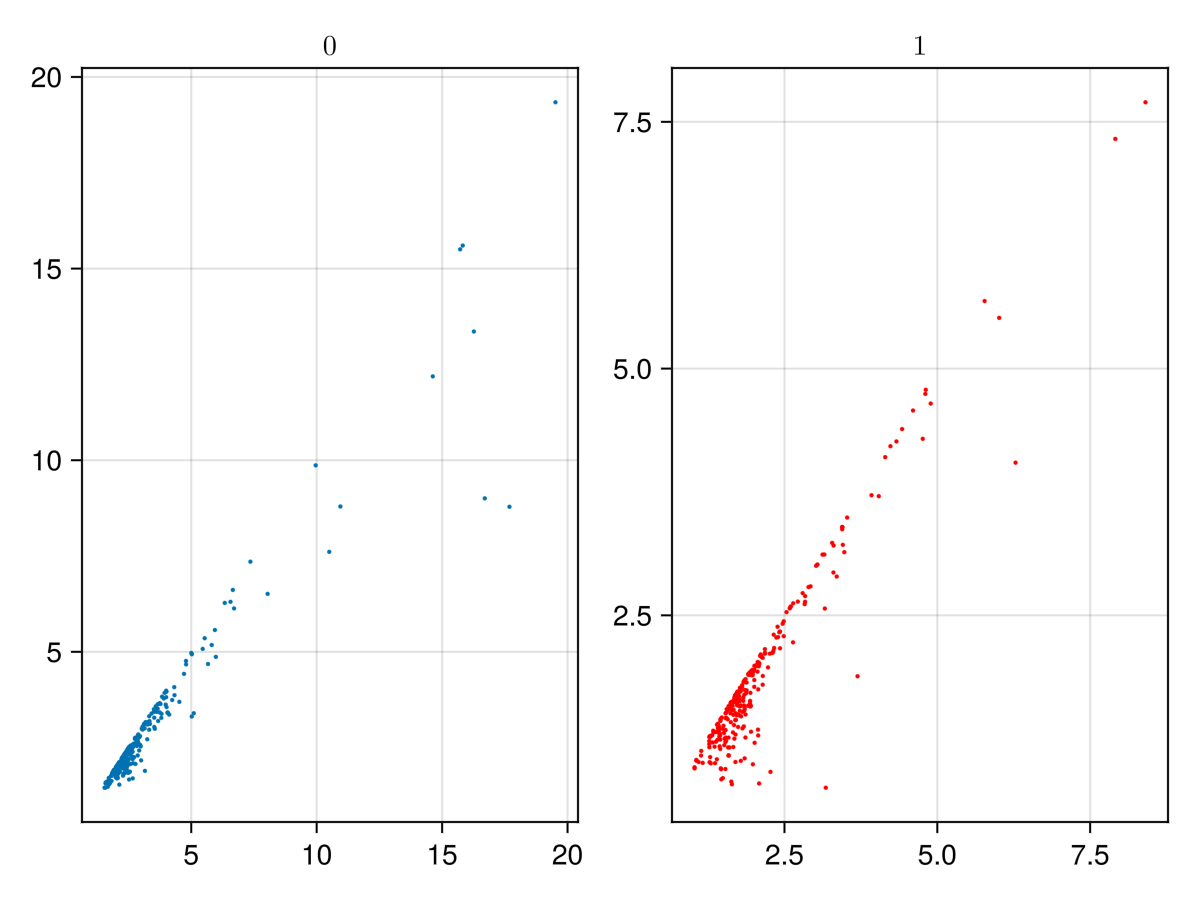

In [21]:
fig = Figure()
gl = GridLayout(fig[1,1])
ms = 3
ax = Axis(gl[1, 1], title = L"0")
scatter!(ax, pd_0[:,1], pd_0[:,2], markersize = ms)
ax = Axis(gl[1, 2], title = L"1")
scatter!(ax, pd_1[:,1], pd_1[:,2], markersize = ms, color = :red)
fig

In [26]:
points = [[0.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.5, 0.0, sqrt(3)/2.0], [0.5, 2.0, 1.0/(2.0*sqrt(3))]]
n_atoms_per_mol = 3
mc_tets = MorphoMol.Energies.get_multichromatic_tetrahedra(points, n_atoms_per_mol)
bcs, filtration = MorphoMol.Energies.get_barycentric_subdivision_and_filtration(points, n_atoms_per_mol)
pd_0 = MorphoMol.Energies.get_interface_persistence_diagram_from_upper_star_filtration(filtration)[1];
pd_1 = MorphoMol.Energies.get_interface_persistence_diagram_from_upper_star_filtration(filtration)[2];

LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/ivanspirandelli/.julia/packages/PyCall/1gn3u/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'IndexError'>
IndexError('index 3 is out of bounds for axis 0 with size 3')
  File "/Users/ivanspirandelli/.julia/packages/PyCall/1gn3u/src/pyeval.jl", line 8, in get_multichromatic_tetrahedra
    get!(_namespaces, m) do
    
  File "/Users/ivanspirandelli/.julia/packages/PyCall/1gn3u/src/pyeval.jl", line 6, in is_multi
  File "/Users/ivanspirandelli/.julia/packages/PyCall/1gn3u/src/pyeval.jl", line 6, in <genexpr>
